## Objective

Find similar clusters of RMs for Manitoba Barley yields.

In [1]:
# Import Libraries
import geopandas as gpd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

## ETL (Extract Transform Load)

<Axes: >

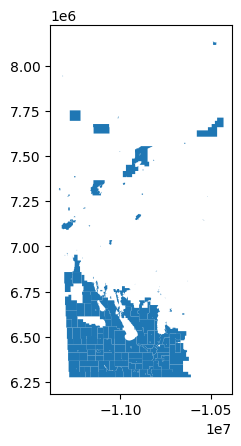

In [2]:
gdf = gpd.read_file(r"C:\Users\lavy_\Downloads\Manitoba_Municipalities\MG_MUNICIPALITY_POLY.shp")
gdf.plot()

In [3]:
# Read in Data
print("\033[1mDATA\033[0m")

data = pd.read_excel(r'C:\Users\lavy_\Downloads\Manitoba_crop_yield_2000_to_2022.xlsx')

print("Data has \033[1m{} rows\033[0m and \033[1m{} columns\033[0m \n".format(data.shape[0], data.shape[1]))

print(f"\n\033[1mThere are {data.duplicated().sum()} rows of duplicated values\033[0m\n")

# Look at data summary and the head rows
print("\n\033[1mOverall data summary below\033[0m")
desc = data.describe(include='all').T
desc['null'] = data.isna().sum()
desc['type'] = data.dtypes
desc['unique'] = data.nunique()
display(desc)


print("\n\033[1mFirst 5 rows of data below\033[0m")
display(data.head())

DATA
Data has 61044 rows and 9 columns 


There are 0 rows of duplicated values


Overall data summary below


,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null,type
Year,61044.0,23,NaN,NaN,2010.476132,6.761885,2000.0,2004.0,2010.0,2016.0,2022.0,0,int64
Risk Area / R.M.,61044,99,PRAIRIE VIEW,1121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
Crop,61044,11,ARGENTINE CANOLA,13404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
Soil,61044,11,E,10151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
Farms,61044,134,Below,36157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
Acres,61044,8059,Minimum,36157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
Yield/acre(Metric),61044,2468,Tolerance,36157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
Yield/acre(Metric).1,24887,1,Tonnes,24887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36157,object
Yield/acre(Imperial),24887,2128,30.3 Bushels,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36157,object



First 5 rows of data below


,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/acre(Metric),Yield/acre(Metric).1,Yield/acre(Imperial)
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452 Tonnes,Tonnes,997 Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449 Tonnes,Tonnes,991 Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,0.449 Tonnes,Tonnes,990 Pounds
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",0.444 Tonnes,Tonnes,980 Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,0.439 Tonnes,Tonnes,968 Pounds


In [4]:
df = data.rename(columns = {'Risk Area / R.M.' : 'RM' , 'Yield/acre(Imperial)' : 'Yield' }).drop(columns = ['Yield/acre(Metric)','Yield/acre(Metric).1'])
df

,Year,RM,Crop,Soil,Farms,Acres,Yield
0,2003,MONTCALM,CANARYSEED,D,7,764,997 Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",991 Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,990 Pounds
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",980 Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,968 Pounds
...,...,...,...,...,...,...,...
61039,2022,YELLOWHEAD,BARLEY,F,Below,Minimum,NaN
61040,2022,YELLOWHEAD,FIELD PEAS,D,Below,Minimum,NaN
61041,2022,YELLOWHEAD,FLAX,B,Below,Minimum,NaN
61042,2022,YELLOWHEAD,FLAX,C,Below,Minimum,NaN


In [5]:
df1 = df['Yield'].str.split(' ' , expand=True).rename(columns={0:'Yield_Float', 1:'Unit'})
df1

,Yield_Float,Unit
0,997,Pounds
1,991,Pounds
2,990,Pounds
3,980,Pounds
4,968,Pounds
...,...,...
61039,NaN,NaN
61040,NaN,NaN
61041,NaN,NaN
61042,NaN,NaN


In [6]:
df2 = pd.concat([df , df1] , axis=1)
df2

,Year,RM,Crop,Soil,Farms,Acres,Yield,Yield_Float,Unit
0,2003,MONTCALM,CANARYSEED,D,7,764,997 Pounds,997,Pounds
1,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",991 Pounds,991,Pounds
2,2003,BIFROST-RIVERTON,CANARYSEED,F,4,517,990 Pounds,990,Pounds
3,2009,MORRIS,CANARYSEED,D,3,"1,072.0",980 Pounds,980,Pounds
4,2002,ROLAND,CANARYSEED,D,6,981,968 Pounds,968,Pounds
...,...,...,...,...,...,...,...,...,...
61039,2022,YELLOWHEAD,BARLEY,F,Below,Minimum,NaN,NaN,NaN
61040,2022,YELLOWHEAD,FIELD PEAS,D,Below,Minimum,NaN,NaN,NaN
61041,2022,YELLOWHEAD,FLAX,B,Below,Minimum,NaN,NaN,NaN
61042,2022,YELLOWHEAD,FLAX,C,Below,Minimum,NaN,NaN,NaN


In [7]:
df2['Yield_Float'] = df2['Yield_Float'].str.replace(',','').astype(float)

In [8]:
df3 = df2.pivot_table(index = ['Year', 'RM', 'Soil', 'Farms', 'Acres', 'Unit'], columns = 'Crop', values = 'Yield_Float')
df3 = df3.reset_index()
df3

Crop,Year,RM,Soil,Farms,Acres,Unit,ALFALFA,ARGENTINE CANOLA,BARLEY,CANARYSEED,DURUM WHEAT,FABABEANS,FIELD PEAS,FLAX,LENTILS,OATS,WINTER WHEAT
0,2000,ALEXANDER,E,6,843,Bushels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.6,NaN
1,2000,ALEXANDER,E,10,"1,509.0",Bushels,NaN,23.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,ALEXANDER,F,8,833,Bushels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.2,NaN
3,2000,ALEXANDER,F,12,"2,401.0",Bushels,NaN,24.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,ALEXANDER,G,10,930,Bushels,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24882,2022,YELLOWHEAD,B,7,"2,336.0",Bushels,NaN,NaN,NaN,NaN,NaN,NaN,64.3,NaN,NaN,NaN,NaN
24883,2022,YELLOWHEAD,B,17,"4,910.0",Bushels,NaN,NaN,81.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24884,2022,YELLOWHEAD,B,49,"28,214.0",Bushels,NaN,44.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24885,2022,REYNOLDS,F,5,629,Bushels,NaN,44.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 72 unique Manitoba Municipalities
#years : 2000-2022
#In the dataset, Barley yield is in Bushels
df4 = df3[['Year','RM','BARLEY']]
df4

Crop,Year,RM,BARLEY
0,2000,ALEXANDER,NaN
1,2000,ALEXANDER,NaN
2,2000,ALEXANDER,NaN
3,2000,ALEXANDER,NaN
4,2000,ALEXANDER,NaN
...,...,...,...
24882,2022,YELLOWHEAD,NaN
24883,2022,YELLOWHEAD,81.9
24884,2022,YELLOWHEAD,NaN
24885,2022,REYNOLDS,NaN


## EDA (Exploratory Data Analysis)

#### Handling Missling Values

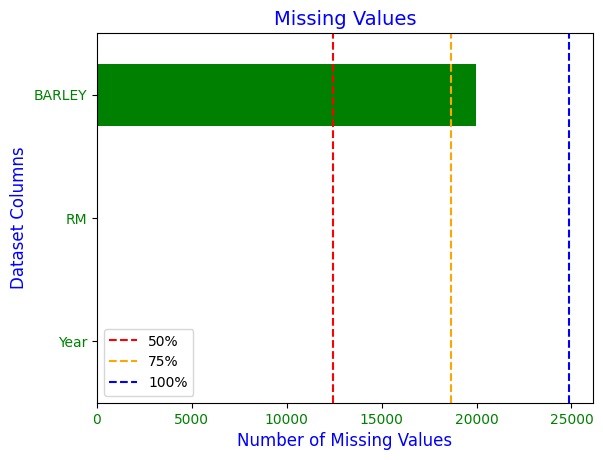

In [10]:
# Checking for missing values

df4.isna().sum()\
    .sort_values()\
    .plot(kind='barh', color='green')
plt.title('Missing Values', color= 'blue', size = 14)
plt.xlabel('Number of Missing Values', color= 'blue', size = 12)
plt.ylabel ('Dataset Columns', color= 'blue', size = 12)
plt.xticks(color='green')
plt.yticks(color='green')
plt.axvline(len(df4)/2, color='red', linestyle='--', label='50%') # half of dataset
plt.axvline(len(df4) * 0.75 , color='orange', linestyle='--', label='75%') # 75% of dataset
plt.axvline(len(df4) , color='blue', linestyle='--', label='100%') # 100% of dataset
plt.legend()
plt.show()

In [11]:
df4.isna().sum()

Crop
Year          0
RM            0
BARLEY    19996
dtype: int64

In [12]:
#Replacing the null value with the mean of each RM.
"""
Replace Null Values with RM Means:
We have a DataFrame called df4. We have 19996 missing values.
We group the data by the ‘RM’  and apply a lambda function.
The lambda function fills any missing (null) values in each group with the mean value of that group.

"""
Barley_yields=df4.groupby('RM').apply(lambda x: x.fillna(x.mean()))
Barley_yields.isna().sum()

Crop
Year       0
BARLEY    63
dtype: int64

In [13]:
#After Replacing the null value with the mean of each RM, there 63 missing values left.
#The remaining 63 missing values are from ARMSTRONG and UNORG TERRITORY RMs 
#However, these two RMs have no Barley yields in the provided dataset. So decided to drop these two RMs
Barley_yields = Barley_yields.dropna(subset=['BARLEY']).reset_index()
Barley_Yields = Barley_yields[['RM','Year','BARLEY']]
Barley_Yields.isna().sum()

Crop
RM        0
Year      0
BARLEY    0
dtype: int64

In [14]:
Barley_Yields.to_excel('Barley_Yields.xlsx')

#### Descriptive analytics

In [15]:
Barley_Yields.describe().drop(columns=['Year'])

Crop,BARLEY
count,24824.000000
mean,64.414541
std,10.727491
min,3.900000
25%,59.386567
50%,65.758974
75%,69.319298
max,116.900000


#### Histogram

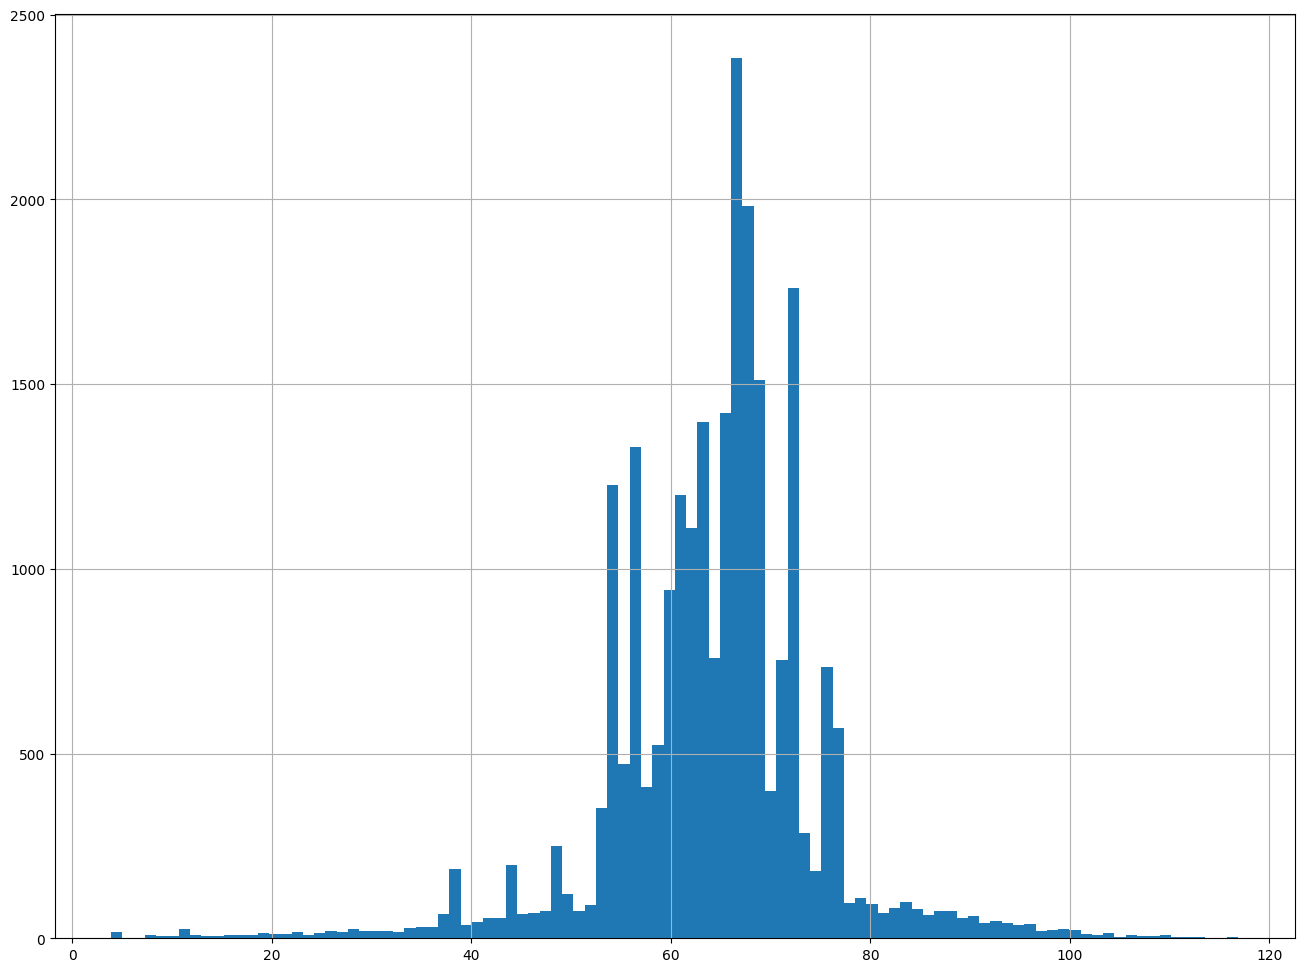

In [16]:
# When training models we want normal dist with zero mean and std of 1
# Data standarization  - zscore, min-max scler 

Barley_Yields['BARLEY'].hist(figsize=(16,12),
                       bins=100)
plt.show()

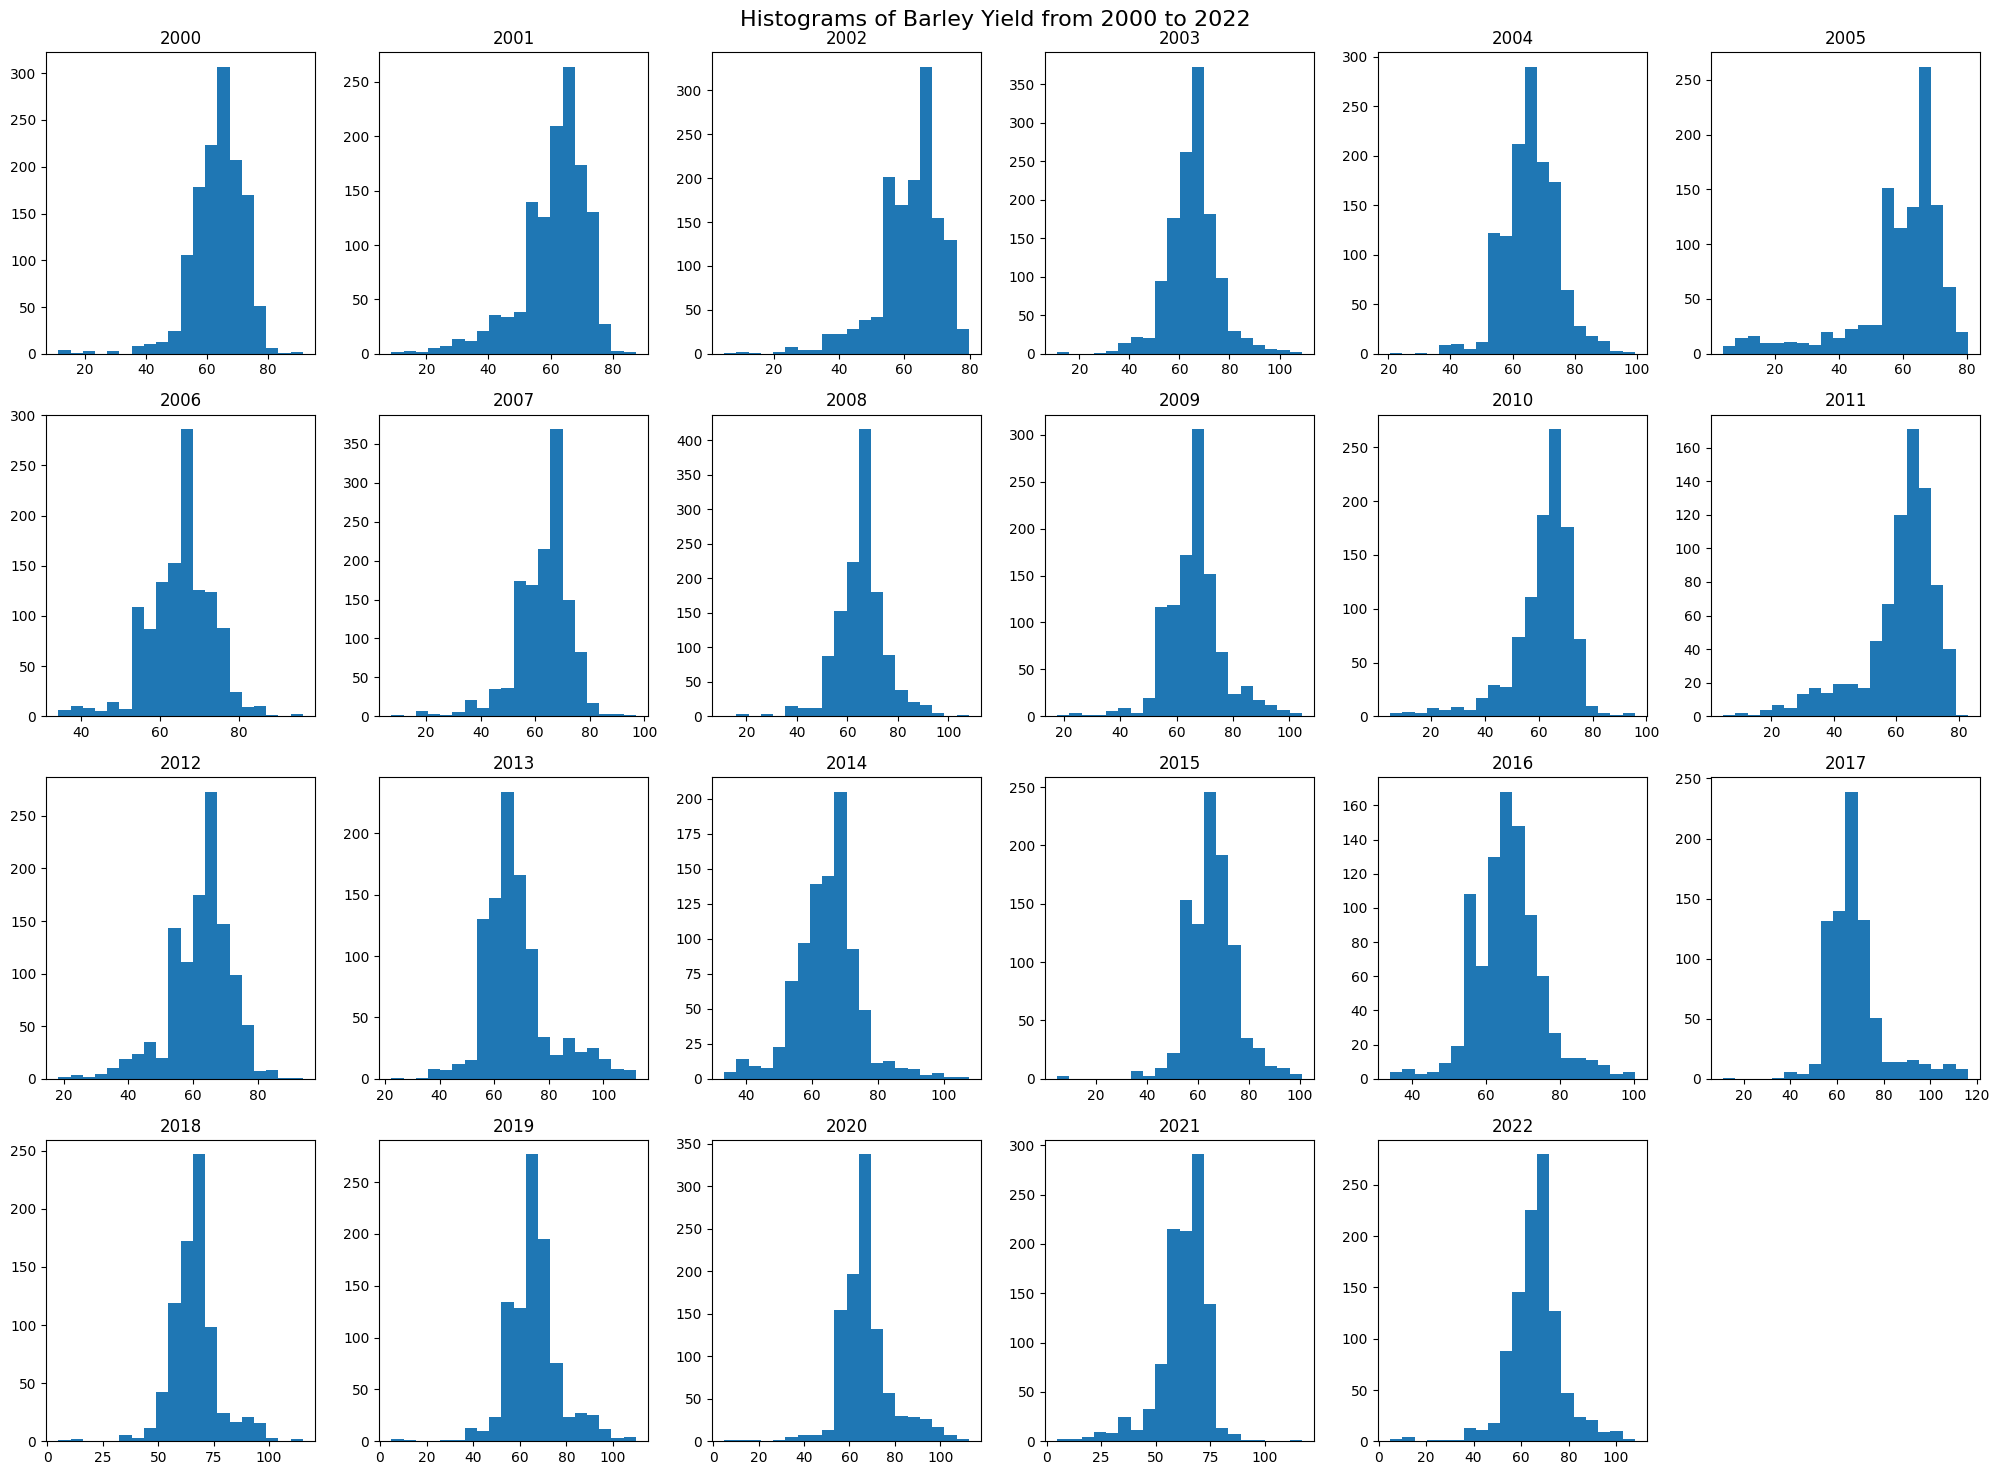

In [17]:
"""
Assuming 'Barley_Yields' has a 'Year' column and BARLEY yield column
And you want to plot histograms for years 2000 to 2022

"""


# Define the range of years you're interested in
start_year = 2000
end_year = 2022
years = range(start_year, end_year + 1)

# Define the layout for subplots
rows = 4
cols = 6
total_plots = rows * cols

# Create a new figure for each crop (in this case, only Barley yields)
fig, axs = plt.subplots(rows, cols, figsize=(20, 15), tight_layout=True)
fig.suptitle(f'Histograms of Barley Yield from {start_year} to {end_year}', fontsize=16)

# Counter for the subplot index
plot_index = 0

for year in years:
    # Select the row where 'Year' equals the current year and the column for Barley yield
    data_for_year = Barley_Yields[Barley_Yields['Year'] == year]['BARLEY']
    
    # Check if the data for the year is not all NaN
    if not data_for_year.isna().all():
        # Plot in the subplot
        ax = axs[plot_index // cols, plot_index % cols]
        ax.hist(data_for_year.dropna(), bins=20)  # Drop NaN values and plot
        ax.set_title(f'{year}')
    else:
        # Handle the case with all NaN values (e.g., by setting the title to indicate no data)
        ax = axs[plot_index // cols, plot_index % cols]
        ax.set_title(f'{year} (No data)')
        ax.set_visible(False)  # Optionally hide the axis for years with no data
    
    # Increment the plot_index
    plot_index += 1
    
    # Break the loop if we have filled all subplots
    if plot_index >= total_plots:
        break

# Hide any unused subplots
for i in range(plot_index, total_plots):
    fig.delaxes(axs.flatten()[i])

plt.show()

#### Boxplots

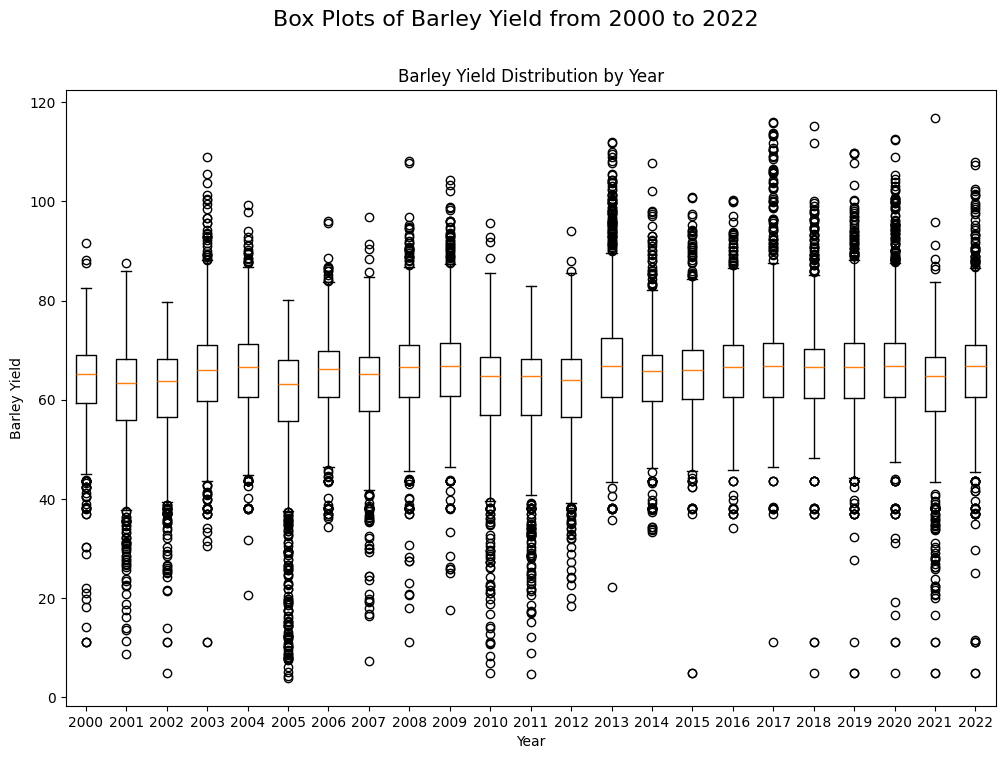

In [18]:
"""
'Barley_Yields' has a 'Year' column and BARLEY yield column
And you want to plot histograms for years 2000 to 2022

"""


# Define the range of years you're interested in
start_year = 2000
end_year = 2022
years = range(start_year, end_year + 1)

# Create a new figure for the box plots
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle(f'Box Plots of Barley Yield from {start_year} to {end_year}', fontsize=16)

# Initialize an empty list to store data for each year
data_by_year = []

for year in years:
    # Select the row where 'Year' equals the current year and the column for Barley yield
    data_for_year = Barley_Yields[Barley_Yields['Year'] == year]['BARLEY']
    
    # Check if the data for the year is not all NaN
    if not data_for_year.isna().all():
        data_by_year.append(data_for_year.dropna())
    
# Create the box plot
ax.boxplot(data_by_year, labels=years)
ax.set_xlabel('Year')
ax.set_ylabel('Barley Yield')
ax.set_title(f'Barley Yield Distribution by Year')

plt.show()

#### Scatter Plots

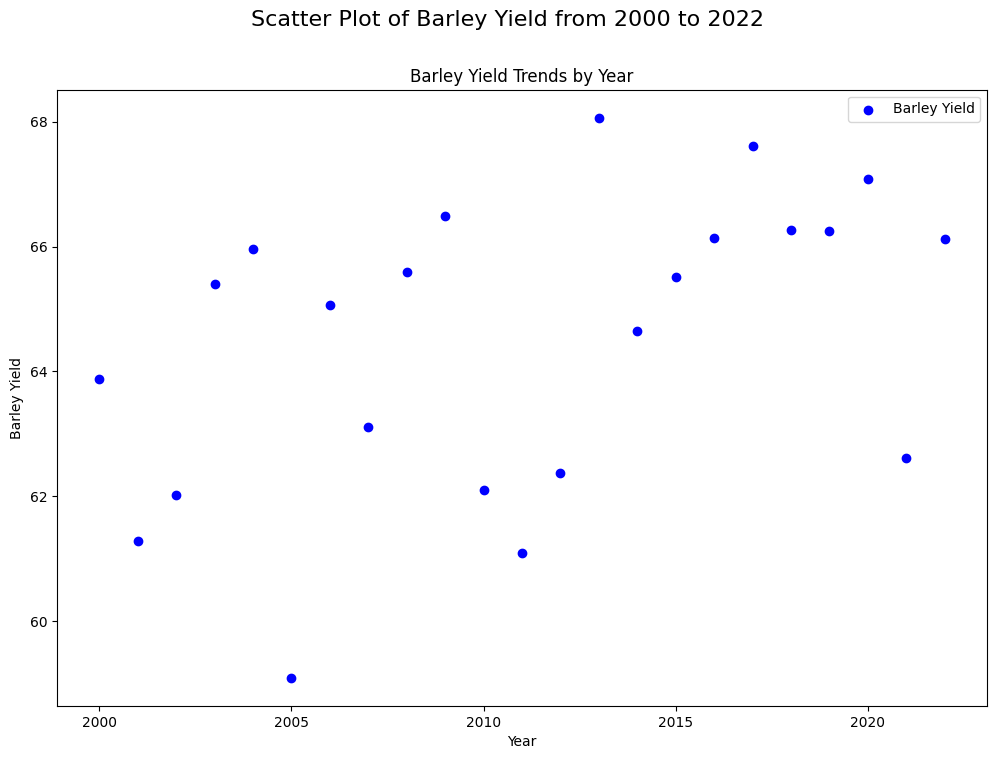

In [19]:
# Define the range of years you're interested in
start_year = 2000
end_year = 2022
years = range(start_year, end_year + 1)

# Create a new figure for the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle(f'Scatter Plot of Barley Yield from {start_year} to {end_year}', fontsize=16)

# Initialize empty lists to store data for x (years) and y (Barley yield)
x_values = []
y_values = []

for year in years:
    # Select the row where 'Year' equals the current year and the column for Barley yield
    data_for_year = Barley_Yields[Barley_Yields['Year'] == year]['BARLEY']
    
    # Check if the data for the year is not all NaN
    if not data_for_year.isna().all():
        x_values.append(year)
        y_values.append(data_for_year.dropna().mean())  # Use mean Barley yield for scatter plot
    
# Create the scatter plot
ax.scatter(x_values, y_values, marker='o', color='b', label='Barley Yield')
ax.set_xlabel('Year')
ax.set_ylabel('Barley Yield')
ax.set_title(f'Barley Yield Trends by Year')
ax.legend()

plt.show()


#### Barplots

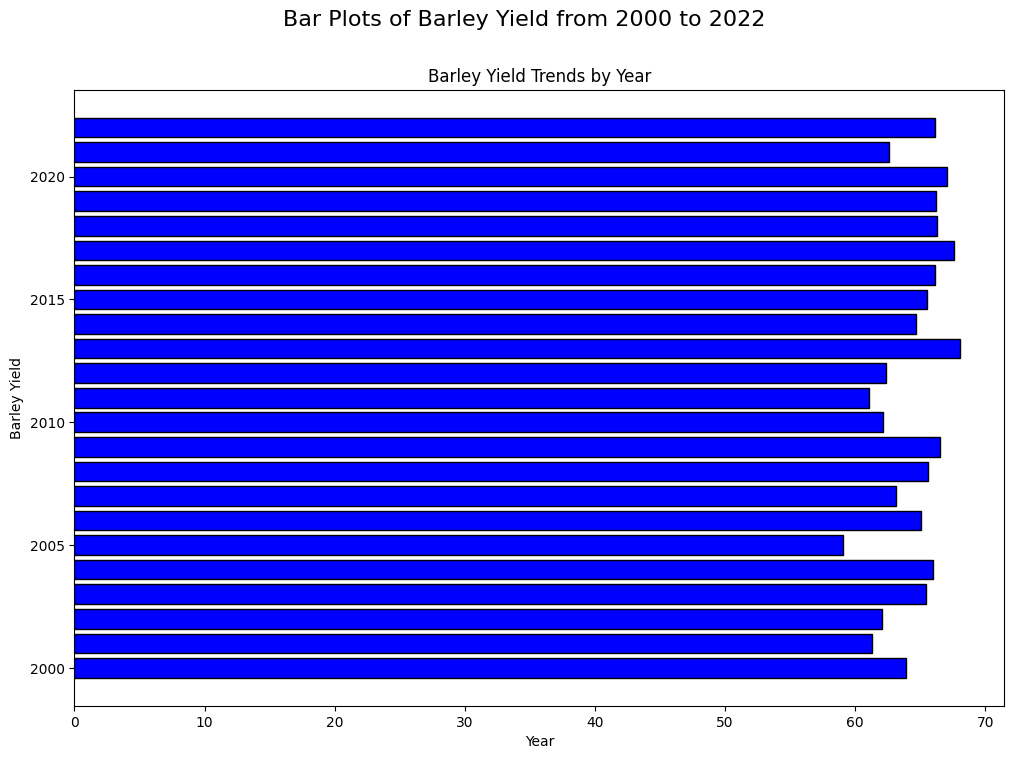

In [20]:
# Define the range of years you're interested in
start_year = 2000
end_year = 2022
years = range(start_year, end_year + 1)

# Create a new figure for the bar plots
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle(f'Bar Plots of Barley Yield from {start_year} to {end_year}', fontsize=16)

# Initialize empty lists to store data for x (years) and y (Barley yield)
x_values = []
y_values = []

for year in years:
    # Select the row where 'Year' equals the current year and the column for Barley yield
    data_for_year = Barley_Yields[Barley_Yields['Year'] == year]['BARLEY']
    
    # Check if the data for the year is not all NaN
    if not data_for_year.isna().all():
        x_values.append(year)
        y_values.append(data_for_year.dropna().mean())  # Use mean Barley yield for bar plot
    
# Create the bar plot
ax.barh(x_values, y_values, color='b', edgecolor='k')
ax.set_xlabel('Year')
ax.set_ylabel('Barley Yield')
ax.set_title(f'Barley Yield Trends by Year')

plt.show()


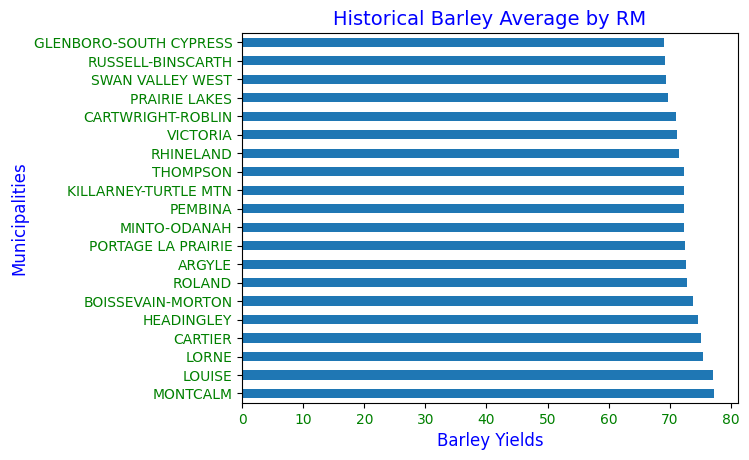

In [21]:
#crop yields by RM
#groupby is function that aggregates data based on index or categorical variable
Barley_Yields.set_index('RM')['BARLEY']\
.groupby('RM').mean()\
.sort_values(ascending=False)[:20]\
.plot(kind='barh')
plt.title('Historical Barley Average by RM', color= 'blue', size = 14)
plt.xlabel('Barley Yields', color= 'blue', size = 12)
plt.ylabel ('Municipalities', color= 'blue', size = 12)
plt.xticks(color='green')
plt.yticks(color='green')
plt.show()

## Unsupervised Learning

In [22]:
# Creating Data Aggregation : mean and std
df_agg=Barley_Yields.set_index(['Year', 'RM'])['BARLEY'].groupby('RM').agg(['mean', 'std'])
# df_agg columns rename
df_agg.rename(columns={'mean': 'Barley_Mean', 'std': 'Barley_Std'}, inplace=True)
df_agg=df_agg.reset_index()
df_agg

,RM,Barley_Mean,Barley_Std
0,ALEXANDER,43.546154,5.882106
1,ALONSA,55.923333,7.623184
2,ARGYLE,72.573737,7.065756
3,BIFROST-RIVERTON,54.520513,10.519979
4,BOISSEVAIN-MORTON,73.807692,5.852241
...,...,...,...
90,WHITEHEAD,54.400943,7.007903
91,WHITEMOUTH,38.225000,7.078318
92,WINNIPEG,53.400000,0.000000
93,WOODLANDS,65.964706,11.765971


#### GIS Analysis

In [23]:
#Selecting columns municipality names and shapes from shapefiles.
gdf.to_file('Manitoba RMs.geojson', driver='GeoJSON')
gdf1 = gdf[['MUNI_LIST_','geometry']].rename(columns={'MUNI_LIST_':'RM'})
gdf1

,RM,geometry
0,SPRINGFIELD,"POLYGON ((-10757459.464 6456526.821, -10757468..."
1,ARGYLE,"POLYGON ((-11060718.858 6365771.762, -11060672..."
2,ROLAND,"POLYGON ((-10879342.025 6350468.886, -10879339..."
3,MONTCALM,"POLYGON ((-10837073.626 6335234.827, -10836852..."
4,FLIN FLON,"MULTIPOLYGON (((-11341354.484 7317922.661, -11..."
...,...,...
178,ST PIERRE-JOLYS,"POLYGON ((-10797902.480 6349510.413, -10797904..."
179,NORWAY HOUSE,"POLYGON ((-10893765.150 7179606.333, -10893746..."
180,PIKWITONEI,"MULTIPOLYGON (((-10817895.865 7479353.767, -10..."
181,ROCK RIDGE,"POLYGON ((-11084093.307 6784800.867, -11084101..."


In [24]:
#Make sure RM names of Barley_Yields and gdf1 datasets match before merging these two tables
df_agg['RM']=df_agg['RM'].str.replace('.','')

In [25]:
#Make sure RM names of Barley_Yields and gdf1 match before merging these two tables
df_agg['RM'] = df_agg['RM'].replace({
    'DESALABERRY': 'DE SALABERRY',
    'KILLARNEY-TURTLE MTN': 'KILLARNEY TURTLE MOUNTAIN',
    'NORFOLK-TREHERNE': 'NORFOLK TREHERNE',
    'ST FRANCIS XAVIER': 'ST FRANCOIS XAVIER',
    'STE ROSE': 'STE. ROSE',
    'HILLSBURG-ROBLIN-SHELL RIVER': 'ROBLIN'
})

In [26]:
#merging Barley_Yields and gdf1 datasets 
#merge default is inner
df_merged = pd.merge(df_agg, gdf1, on = 'RM', how = 'inner')

In [27]:
set(df_agg['RM'])-set(df_merged['RM'])

set()

In [28]:
gdf_merged = gpd.GeoDataFrame(df_merged)
gdf_merged

,RM,Barley_Mean,Barley_Std,geometry
0,ALEXANDER,43.546154,5.882106,"POLYGON ((-10741721.346 6564808.271, -10741693..."
1,ALONSA,55.923333,7.623184,"POLYGON ((-11068902.736 6701102.482, -11068870..."
2,ARGYLE,72.573737,7.065756,"POLYGON ((-11060718.858 6365771.762, -11060672..."
3,BIFROST-RIVERTON,54.520513,10.519979,"POLYGON ((-10792306.087 6588969.860, -10792319..."
4,BOISSEVAIN-MORTON,73.807692,5.852241,"POLYGON ((-11149881.469 6335347.408, -11148653..."
...,...,...,...,...
96,WHITEHEAD,54.400943,7.007903,"POLYGON ((-11182160.293 6426669.395, -11180902..."
97,WHITEMOUTH,38.225000,7.078318,"POLYGON ((-10689029.839 6466907.827, -10688976..."
98,WINNIPEG,53.400000,0.000000,"POLYGON ((-10818486.762 6442052.425, -10818439..."
99,WOODLANDS,65.964706,11.765971,"POLYGON ((-10849187.776 6519071.783, -10849175..."


In [29]:
gdf_merged.to_excel('gdf_merged.xlsx')

In [30]:
gdf_merged.to_file('gdf_merged.geojson', driver='GeoJSON')

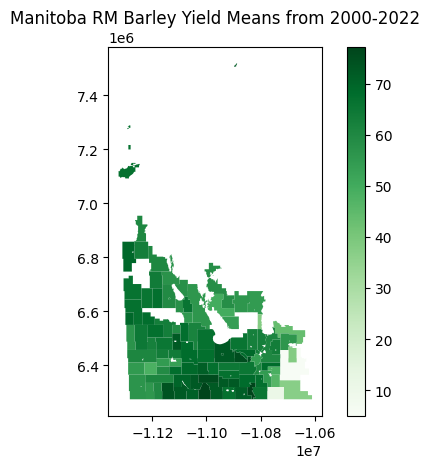

In [31]:
gdf_merged.plot('Barley_Mean', legend=True, cmap='Greens')
plt.title('Manitoba RM Barley Yield Means from 2000-2022', size=12)
plt.show()

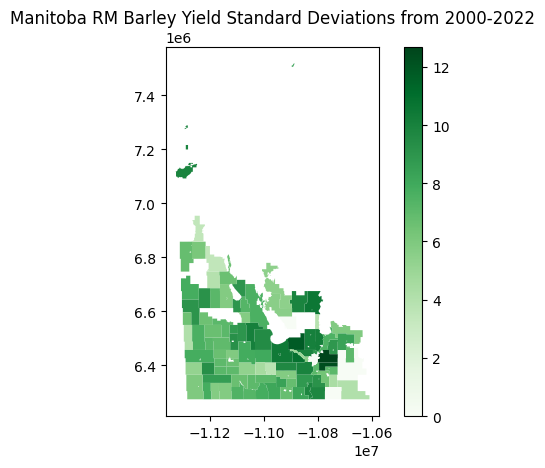

In [32]:
gdf_merged.plot('Barley_Std', legend=True, cmap='Greens')
plt.title('Manitoba RM Barley Yield Standard Deviations from 2000-2022', size=12)
plt.show()

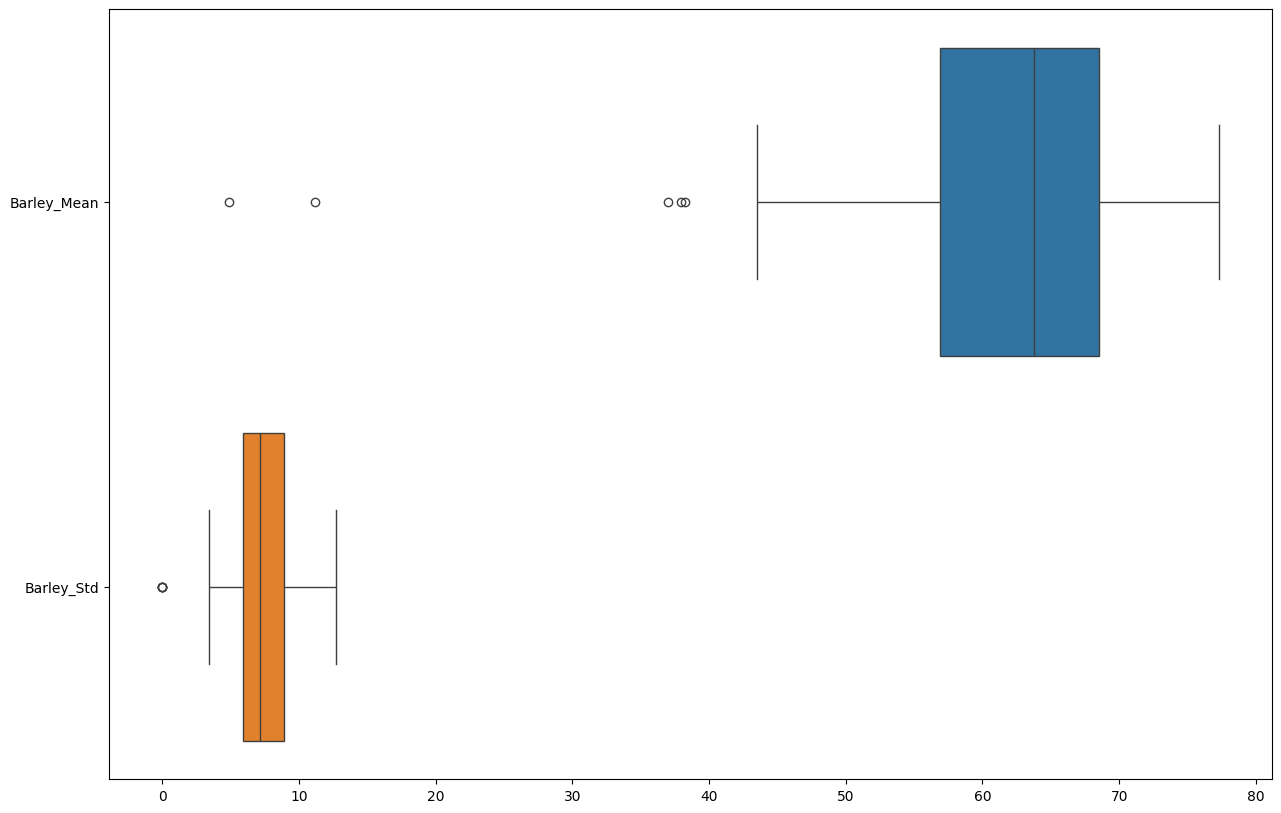

In [33]:
columns = ['Barley_Mean', 'Barley_Std']
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.boxplot(data=df_merged[columns], ax=ax, orient='h')
plt.show()

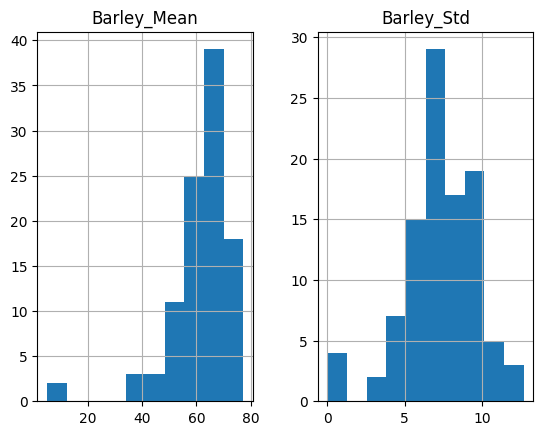

In [34]:
df_merged[columns].hist()
plt.show()

#### K Means Clustering

In [35]:
# Let's define our features
X = df_agg.set_index('RM')

n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM = KMeans(n_clusters=n, random_state=8, init='k-means++').fit(X)
    clusters_inertia.append(KM.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(X, KM.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

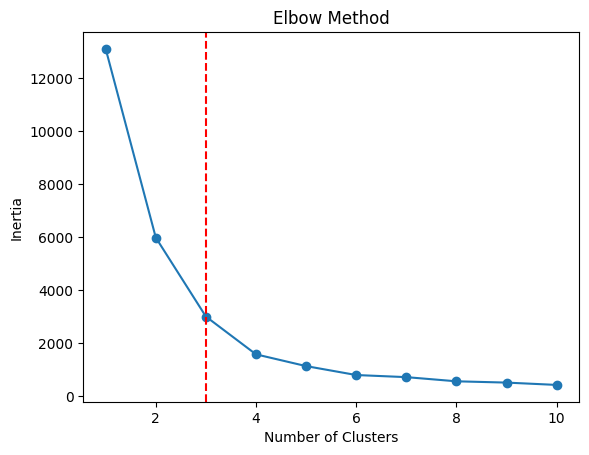

In [36]:
max_clusters = 10

# Perform K-means clustering for different number of clusters
inertia = []
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.axvline(3, ls="--", c="red")
plt.show()

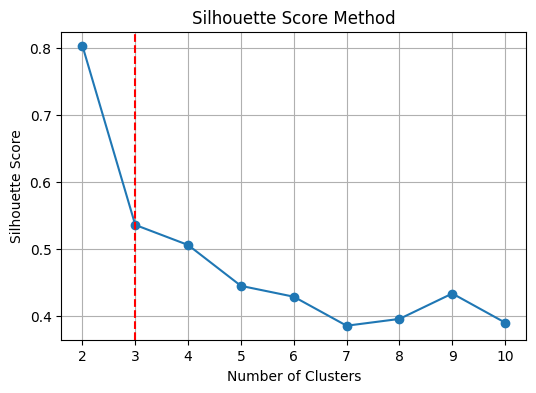

In [37]:
# Set the range of clusters to test
min_clusters = 2
max_clusters = 10

# Perform K-means clustering for different number of clusters
n_clusters = range(min_clusters, max_clusters + 1)
s_scores = []
for k in n_clusters:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)
    s_score = silhouette_score(X, labels)
    s_scores.append(s_score)

# Plot the silhouette scores
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(n_clusters, s_scores, marker='o')
ax.set_title("Silhouette Score Method")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
ax.axvline(3, ls="--", c="red")
ax.grid(True)
plt.show()

Based on results of the Elbow Method and Silhouette score, I will try clustering Barley yields with 3 and 4 clusters.

In [38]:
# Cluster 3
df_3_clusters = KMeans(n_clusters=3, init='k-means++').fit(X) # initialise and fit K-Means model

df_3= X.copy()
df_3.loc[:,'Clusters'] = df_3_clusters.labels_ # append labels to points

# Clusters 4
df_4_clusters = KMeans(n_clusters=4, init='k-means++').fit(X) # initialise and fit K-Means model

df_4= X.copy()
df_4.loc[:,'Clusters'] = df_4_clusters.labels_ # append labels to points



#### 3-Clusters Ranking

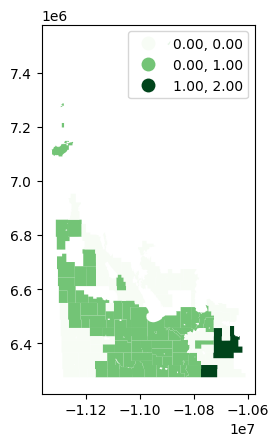

In [39]:
gpd.GeoDataFrame(pd.merge(df_3,gdf1, on='RM' )).plot('Clusters', cmap='Greens', scheme='naturalbreaks', k=3, legend=True)
plt.show()

In [40]:
df_3.groupby('Clusters').mean().sort_values('Barley_Mean')

,Barley_Mean,Barley_Std
Clusters,,
2,8.050000,0.000000
0,53.932867,6.500222
1,67.987529,7.872084


In [41]:
df_3['Cl_3_Rank']=df_3['Clusters'].replace(to_replace={
    1:0,
    0:1,
    2:2
})

In [42]:
df_3

,Barley_Mean,Barley_Std,Clusters,Cl_3_Rank
RM,,,,
ALEXANDER,43.546154,5.882106,0,1
ALONSA,55.923333,7.623184,0,1
ARGYLE,72.573737,7.065756,1,0
BIFROST-RIVERTON,54.520513,10.519979,0,1
BOISSEVAIN-MORTON,73.807692,5.852241,1,0
...,...,...,...,...
WHITEHEAD,54.400943,7.007903,0,1
WHITEMOUTH,38.225000,7.078318,0,1
WINNIPEG,53.400000,0.000000,0,1


In [43]:
gpd.GeoDataFrame(pd.merge(
    df_3,
    gdf1,
     on='RM' )).to_file('Barley 3-Cluster Data.geojson', driver='GeoJSON')

#### 4-Clusters Ranking

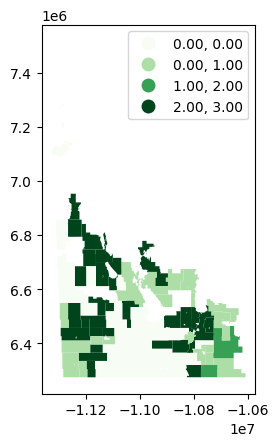

In [44]:
gpd.GeoDataFrame(pd.merge(df_4,gdf1, on='RM' )).plot('Clusters', cmap='Greens', scheme='naturalbreaks', k=4, legend=True)
plt.show()

In [45]:
df_4.groupby('Clusters').mean().sort_values('Barley_Mean')

,Barley_Mean,Barley_Std
Clusters,,
2,8.050000,0.000000
1,50.955104,6.032151
3,62.037836,7.933756
0,70.019912,7.670168


In [46]:
df_4['Cl_4_Rank']=df_4['Clusters'].replace(to_replace={
    0:0,
    3:1,
    1:2,
    2:3
})

In [47]:
df_4

,Barley_Mean,Barley_Std,Clusters,Cl_4_Rank
RM,,,,
ALEXANDER,43.546154,5.882106,1,2
ALONSA,55.923333,7.623184,1,2
ARGYLE,72.573737,7.065756,0,0
BIFROST-RIVERTON,54.520513,10.519979,1,2
BOISSEVAIN-MORTON,73.807692,5.852241,0,0
...,...,...,...,...
WHITEHEAD,54.400943,7.007903,1,2
WHITEMOUTH,38.225000,7.078318,1,2
WINNIPEG,53.400000,0.000000,1,2


In [48]:
gpd.GeoDataFrame(pd.merge(
    df_4,
    gdf1,
     on='RM' )).to_file('Barley 4-Cluster Data.geojson', driver='GeoJSON')

## Conclusion and Future Work

It is possible to cluster Manitoba RMs based on Barley yield mean and standard deviation. Different clusters were created and maybe follow a similar approach to the soil type map of Manitoba.